In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))
from tensorflow.keras import layers, models, preprocessing

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/MyDrive/pawpatrol/petfinder-pawpularity-score.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  gdrive/MyDrive/pawpatrol/petfinder-pawpularity-score.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
url = 'https://raw.githubusercontent.com/Veer56/Pawl_patrol/main/Code/data/train.csv'
train_data = pd.read_csv(url)
train_data['Pawpularity'] = train_data['Pawpularity']
display(train_data.head(5))

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [21]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder, data = [], size=128):
    images = []
    labels = []
    names = []
    for filename in os.listdir(folder):
        name = filename.strip('.jpg')
        names.append(name)
        labels.append(data.loc[data['Id']== name]['Pawpularity'])
        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (size, size))
        if img is not None:
            images.append(img)
    return np.array(images), labels, names

image_images, image_labels, image_names = load_images_from_folder('train', data = train_data)

print(f'Training labels loaded: {image_images.shape}')

Training labels loaded: (9912, 128, 128, 3)


In [22]:
image_images = image_images


In [23]:
from sklearn.model_selection import train_test_split
image_train, image_test, label_train, label_test, name_train, name_test = train_test_split(image_images, image_labels, image_names, test_size=0.33, random_state=42)

In [26]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    model.compile(loss='mse', optimizer='adam', metrics=['RootMeanSquaredError'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"The validation root_mean_squared_error: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

Epoch 1/20
208/208 [==============================] - 33s 156ms/step - loss: 1821727.8750 - root_mean_squared_error: 1349.7140 - val_loss: 496.5204 - val_root_mean_squared_error: 22.2827
Epoch 2/20
208/208 [==============================] - 32s 155ms/step - loss: 484.7282 - root_mean_squared_error: 22.0165 - val_loss: 519.5282 - val_root_mean_squared_error: 22.7932
Epoch 3/20
208/208 [==============================] - 32s 155ms/step - loss: 463.8556 - root_mean_squared_error: 21.5373 - val_loss: 515.9863 - val_root_mean_squared_error: 22.7153
Epoch 4/20
208/208 [==============================] - 32s 155ms/step - loss: 435.6915 - root_mean_squared_error: 20.8732 - val_loss: 493.7058 - val_root_mean_squared_error: 22.2195
Epoch 5/20
208/208 [==============================] - 32s 155ms/step - loss: 401.7788 - root_mean_squared_error: 20.0444 - val_loss: 566.3378 - val_root_mean_squared_error: 23.7979
Epoch 6/20
208/208 [==============================] - 32s 154ms/step - loss: 365.3151 - r

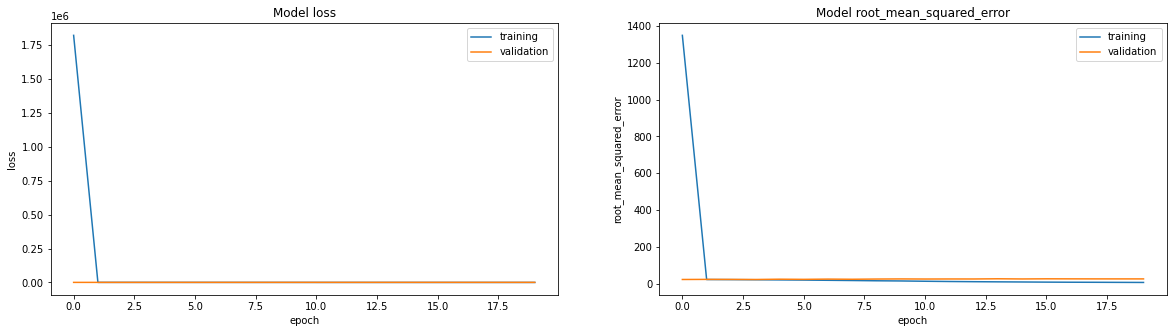

103/103 [==============================] - 4s 38ms/step - loss: 647.0942 - root_mean_squared_error: 25.4380
Validation Accuracy: 25.438047409057617


In [27]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


train_and_evaluate(model, image_train, label_train, image_test, label_test)

In [28]:
    test_images = []
    
    test_names = []
    for filename in os.listdir('test'):
        name = filename.strip('.jpg')
        test_names.append(name)
        img = cv2.imread(os.path.join('test',filename))
        if img is not None:
            test_images.append(img)

In [29]:
test_images = np.array(test_images)
model.predict(test_images)

array([[23.843912],
       [31.398142],
       [28.371939],
       [41.517563],
       [34.79773 ],
       [43.61006 ],
       [45.29967 ],
       [49.519005]], dtype=float32)